Sammy Pardes<br>
IST 718<br>
Lab 2<br>
8/18/2021

#### Helpful Resources

https://stackoverflow.com/questions/28654047/pandas-convert-some-columns-into-rows<br>
https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html<br>
https://stackoverflow.com/questions/26105804/extract-month-from-date-in-python/26105888<br>
https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe<br>
https://stackoverflow.com/questions/29370057/select-dataframe-rows-between-two-dates<br>
https://github.com/facebook/prophet/issues/1874<br>
https://stackoverflow.com/questions/50808322/prophet-fbprophet-package-in-python<br>
https://facebook.github.io/prophet/docs/quick_start.html#python-api<br>
https://www.youtube.com/watch?v=UhxCsweuKE4<br>
https://facebook.github.io/prophet/docs/non-daily_data.html<br>
https://www.reit.com/what-reit<br>
https://www.shanelynn.ie/pandas-iloc-loc-select-rows-and-columns-dataframe/<br>
https://stackoverflow.com/questions/26336251/pandas-rename-single-dataframe-column-without-knowing-column-name<br>
https://re-thought.com/how-to-suppress-scientific-notation-in-pandas/

#### Data Sources

https://data.cityofnewyork.us/City-Government/Broadband-Adoption-and-Infrastructure-by-Zip-Code/qz5f-yx82/data

In [1]:
# Install statements

#!pip install pystan==2.19.1.1 prophet
#!pip install pystan


In [2]:
# Import statements

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import datetime as dt
from prophet import Prophet
import requests
from sklearn.metrics import mean_squared_error


Importing plotly failed. Interactive plots will not work.


In [3]:
# Obtain - load zillow data

zillow = pd.read_csv("https://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_SingleFamilyResidence.csv")
zillow.shape
#zillow.head()


(30464, 300)

In [4]:
# Scrub - melt data frame so date values are in one column

zillow_melt = zillow.melt(id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
                                    'State', 'City', 'Metro', 'CountyName'],
               var_name = "Date",
               value_name = "HomeValue"
              )

zillow_melt.shape
zillow_melt.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,HomeValue
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1996-01-31,NaN
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,1996-01-31,364892.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1996-01-31,NaN
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,1996-01-31,200475.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,1996-01-31,546663.0


In [5]:
# Convert Dates to datetime datetypes

zillow_melt['Date'] = pd.to_datetime(zillow_melt['Date'], format = '%Y-%m-%d')

# Add new month column
#zillow_melt['Month'] = zillow_melt['Date'].dt.month

zillow_melt.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,HomeValue
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1996-01-31,NaN
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,1996-01-31,364892.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1996-01-31,NaN
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,1996-01-31,200475.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,1996-01-31,546663.0


### Part I: Arkansas

In [6]:
# Get data from 1997-present 

zillow_melt_97 = zillow_melt[zillow_melt['Date'] >= '1997-01-01']

zillow_melt_97.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,HomeValue
8865019,58111,35187,802,Zip,UT,UT,Charlotte Amalie,NaN,Kane County,2020-03-31,132127.0
8865020,58115,35187,820,Zip,LA,LA,Choudrant,Ruston,Lincoln Parish,2020-03-31,100708.0
8865021,58117,35187,822,Zip,LA,LA,Choudrant,Ruston,Lincoln Parish,2020-03-31,181195.0
8865022,58121,35187,831,Zip,AL,AL,Logan,Cullman,Cullman County,2020-03-31,75464.0
8865023,58125,35187,851,Zip,CO,CO,Granby,NaN,Grand County,2020-03-31,456250.0


In [7]:
# Isolate AR data

arkansas = zillow_melt_97[zillow_melt_97['State'] == 'AR']

arkansas['Metro'].unique()

hot_springs = arkansas[arkansas['Metro'] == 'Hot Springs']
little_rock = arkansas[arkansas['Metro'] == 'Little Rock-North Little Rock-Conway']
fayetteville = arkansas[arkansas['Metro'] == 'Fayetteville-Springdale-Rogers']
searcy = arkansas[arkansas['Metro'] == 'Searcy']


In [8]:
# Group by average price in each metro area

hot_springs_group = hot_springs.groupby(['Date'])['HomeValue'].mean().reset_index()
little_rock_group = little_rock.groupby(['Date'])['HomeValue'].mean().reset_index()
fayetteville_group = fayetteville.groupby(['Date'])['HomeValue'].mean().reset_index()
searcy_group = searcy.groupby(['Date'])['HomeValue'].mean().reset_index()

searcy_group.head()

,Date,HomeValue
0,1997-01-31,57560.583333
1,1997-02-28,57887.666667
2,1997-03-31,58211.000000
3,1997-04-30,58466.000000
4,1997-05-31,58640.083333


Text(0, 0.5, 'Average Home Value')

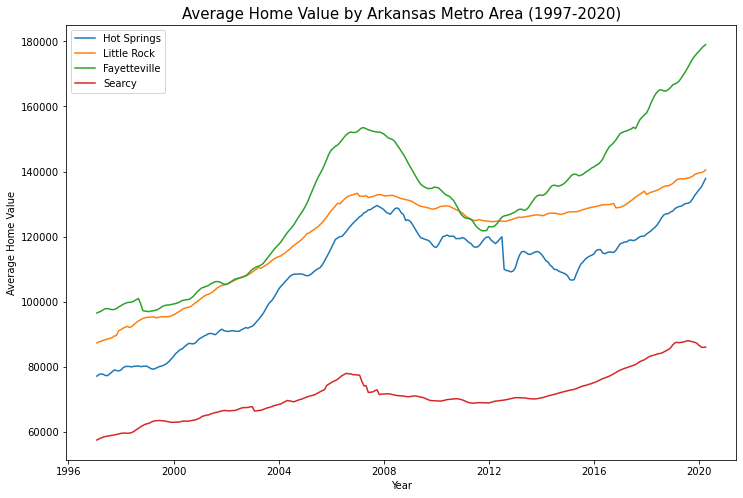

In [9]:
# Time series plot for the 4 AR metro areas 

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

sns.lineplot(ax = ax, data = hot_springs_group, x = 'Date', y = 'HomeValue'
             , label = 'Hot Springs', ci = None)
sns.lineplot(ax = ax, data = little_rock_group, x = 'Date', y = 'HomeValue'
             , label = 'Little Rock', ci = None)
sns.lineplot(ax = ax, data = fayetteville_group, x = 'Date', y = 'HomeValue'
             , label = 'Fayetteville', ci = None)
sns.lineplot(ax = ax, data = searcy_group, x = 'Date', y = 'HomeValue'
             , label = 'Searcy', ci = None)

ax.set_title('Average Home Value by Arkansas Metro Area (1997-2020)', fontsize = 15)
ax.set_xlabel('Year')
ax.set_ylabel('Average Home Value')


### Part II: SREIT Investment Analysis

In [10]:
# Subset data

# Get data from 1997-2018

zillow_97_18 = zillow_melt[(zillow_melt['Date'] >= '1997-01-01') & (zillow_melt['Date'] <= '2018-12-31')]


In [11]:
# Get NY data 

new_york = zillow_97_18[zillow_97_18['State'] == 'NY']

new_york['Metro'].unique()


array(['New York-Newark-Jersey City', 'Ithaca', 'Rochester',
       'Buffalo-Cheektowaga-Niagara Falls', 'Albany-Schenectady-Troy',
       'Binghamton', 'Auburn', 'Utica-Rome', 'Watertown-Fort Drum',
       'Jamestown-Dunkirk-Fredonia', 'Kingston', 'Syracuse',
       'Plattsburgh', 'Amsterdam', 'Glens Falls', 'Cortland',
       'Gloversville', 'Batavia', 'Elmira', 'Corning', 'Olean', 'Oneonta',
       'Hudson', 'Ogdensburg-Massena', nan, 'Malone', 'Seneca Falls'],
      dtype=object)

In [12]:
# Get NYC data - major metro areas

ny_list = ['New York-Newark-Jersey City']

nyc = new_york[new_york['Metro'].isin(ny_list)]

#len(nyc)
len(nyc['RegionID'].unique())


535

In [13]:
# Try modeling with one zip code

#tribeca = nyc[nyc['RegionName'] == 10013]

# Group by zip code
#tribeca_group = tribeca.groupby(['Date'])['HomeValue'].mean().reset_index()

# Rename columsn for Prophet
#tribeca_group = tribeca_group.rename(columns={"Date": "ds", "HomeValue": "y"})

#tribeca_group

# Extract 2018 for training/testing

#tribeca_train = tribeca_group[tribeca_group['ds'] < '2018-01-01']
#tribeca_test = tribeca_group[tribeca_group['ds'] >= '2018-01-01']

#tribeca_train
#tribeca_test

# Plot training data time series 

#sns.lineplot(data = tribeca_train, x = 'ds', y = 'y')

# Run prophet on training data

#proph = Prophet()
#proph.fit(tribeca_train)

# Predict the future!!

#future = proph.make_future_dataframe(periods = 12, freq = "M")
#future

# Forecast 
#forecast = proph.predict(future)
#forecast_small = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#forecast_small

# Plot forecast

#proph.plot(forecast, uncertainty = True)

# Check prediction vs. actual

#results = pd.concat([forecast_small[forecast_small['ds'] >= '2018-01-01'], tribeca_test], axis = 1)

#results[['ds', 'yhat', 'y']]

In [14]:
# Load additional broadband data

broadband = pd.read_csv('Broadband_Adoption_and_Infrastructure_by_Zip_Code.csv')

# Get column for low internet access
#broadband['low_access'] = broadband['No Internet Access (Percentage of Households)'] >= 0.25

# Get column for high internet access
broadband['high_access'] = broadband['No Internet Access (Percentage of Households)'] <= 0.06

# Drop extraneous columns
broadband = broadband.drop(columns = ['OID',
        'No Internet Access (Percentage of Households)',
        'Home Broadband Adoption (Percentage of  Households)',
        'Mobile Broadband Adoption (Percentage of Households)',
        'No Home Broadband Adoption (Percentage of  Households)',
        'No Mobile Broadband Adoption (Percentage of Households)',
        'No Home Broadband Adoption by Quartile',
        'No Mobile Broadband Adoption by Quartile',
        'Commercial Fiber Max ISP Choice', 'Public Computer Center Count',
        'Workstations in PCCs', 'Avg training hrs per week in PCCs',
        'Public Wi-Fi Count', 'Poles Reserved by Mobile Telecom Franchisee',
        'Pole with Equipment Installed by Mobile Telecom Franchise',
        'Density of Poles Reserved and with Equipment Installed for Mobile Telecom Franchise'])

broadband_high = broadband[broadband['high_access'] == True]
broadband_high.head()

,Zip Code,high_access
4,10004,True
5,10005,True
6,10006,True
10,10011,True
15,10017,True


In [15]:
# Merge with NYC data

nyc_broadband = nyc.merge(broadband_high, left_on = 'RegionName', right_on = 'Zip Code')

print(len(nyc_broadband['RegionName'].unique()))

nyc_broadband.head()

12


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,HomeValue,Zip Code,high_access
0,61625,30,10011,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1997-01-31,NaN,10011,True
1,61625,30,10011,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1997-02-28,NaN,10011,True
2,61625,30,10011,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1997-03-31,NaN,10011,True
3,61625,30,10011,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1997-04-30,NaN,10011,True
4,61625,30,10011,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,1997-05-31,NaN,10011,True


In [16]:
# Rename columns for Prophet

nyc_broadband = nyc_broadband.rename(columns = {'Date':'ds', 'HomeValue':'y'})
nyc_broadband

# drop unwanted columns 
nyc_broadband.columns
nyc_broadband = nyc_broadband.drop(columns = ['SizeRank', 'RegionID', 'RegionType', 'StateName',
                                              'State', 'City', 'Metro', 'CountyName' , 'Zip Code'])

nyc_broadband

,RegionName,ds,y,high_access
0,10011,1997-01-31,NaN,True
1,10011,1997-02-28,NaN,True
2,10011,1997-03-31,NaN,True
3,10011,1997-04-30,NaN,True
4,10011,1997-05-31,NaN,True
...,...,...,...,...
3163,10004,2018-08-31,1226582.0,True
3164,10004,2018-09-30,1235670.0,True
3165,10004,2018-10-31,1241368.0,True
3166,10004,2018-11-30,1232509.0,True


In [17]:
# Create test/train sets

nyc_broadband_train = nyc_broadband[nyc_broadband['ds'] <= '2017-12-31']
nyc_broadband_test = nyc_broadband[nyc_broadband['ds'] > '2018-01-01']


In [18]:
# Group by zip code

nyc_group_train = nyc_broadband_train.groupby('RegionName')
nyc_group_test = nyc_broadband_test.groupby('RegionName')

len(nyc_group_train.head()['RegionName'].unique())

12

In [19]:
# Show grouped DFs

#for zipcode in nyc_group_train.groups:
#    group = nyc_group_train.get_group(zipcode)
#    print(group)
    

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonali

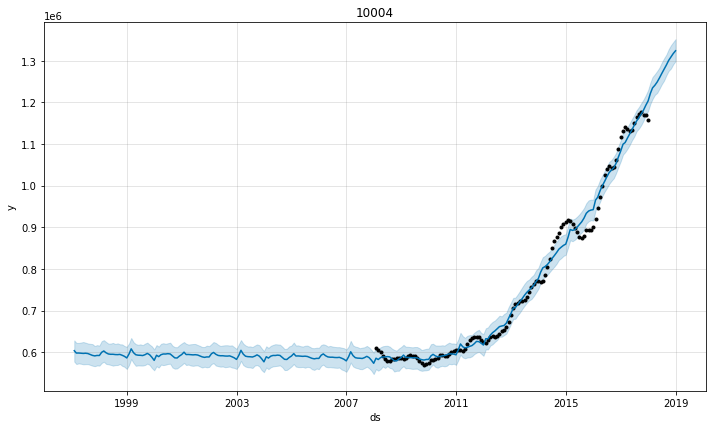

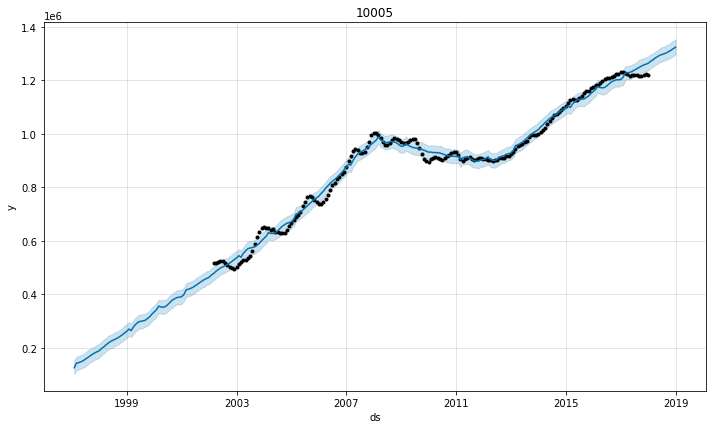

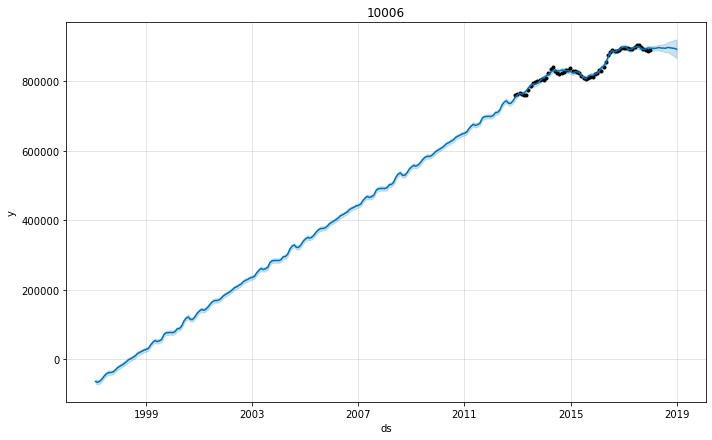

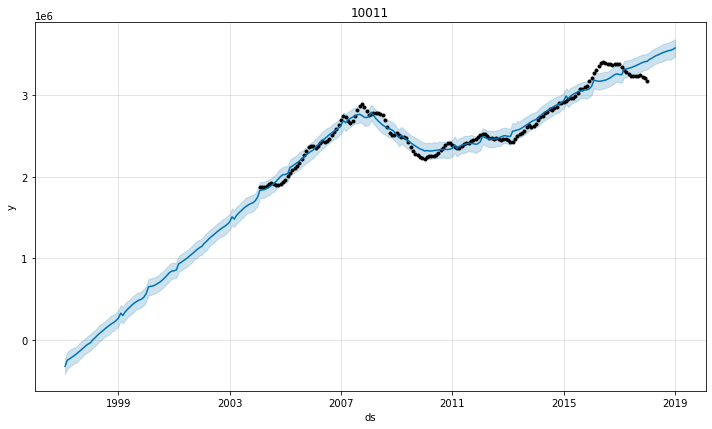

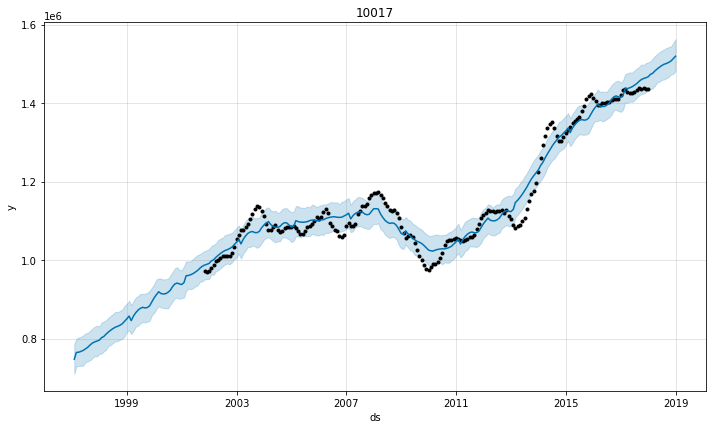

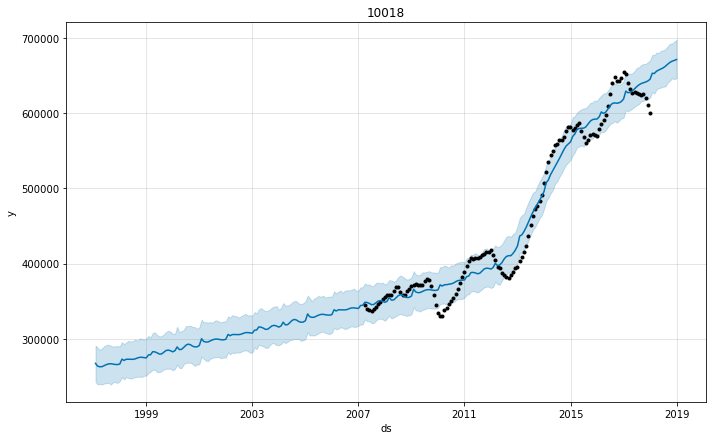

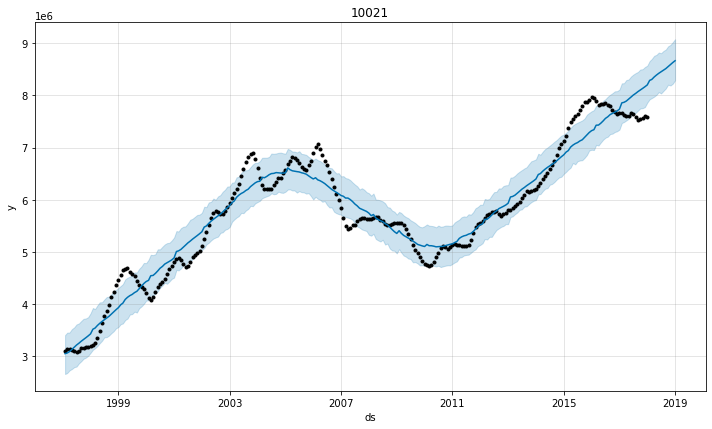

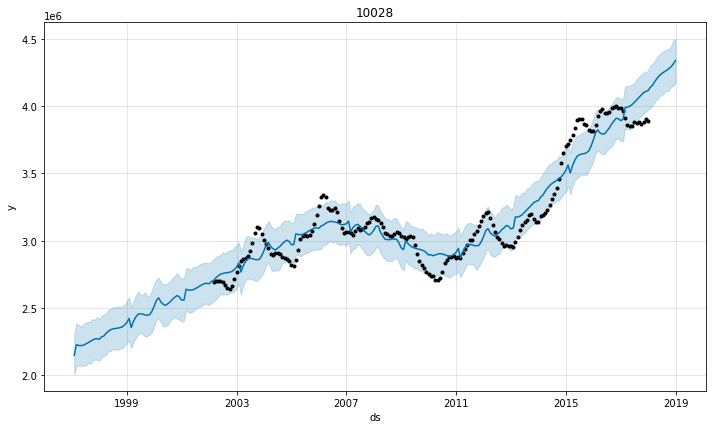

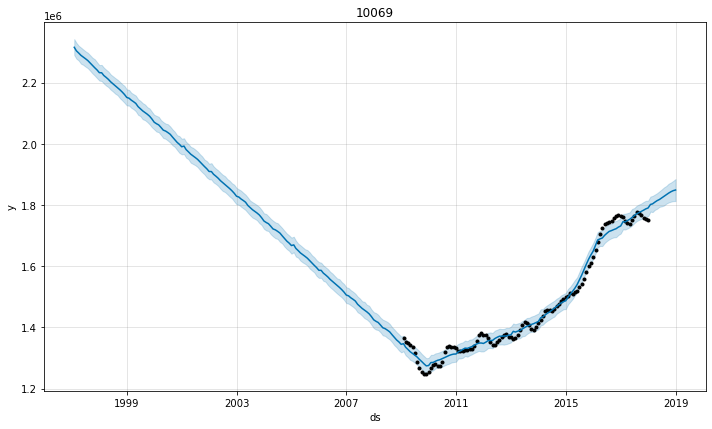

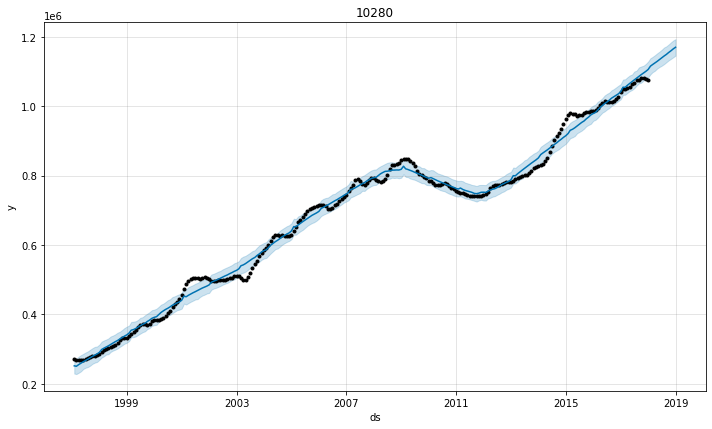

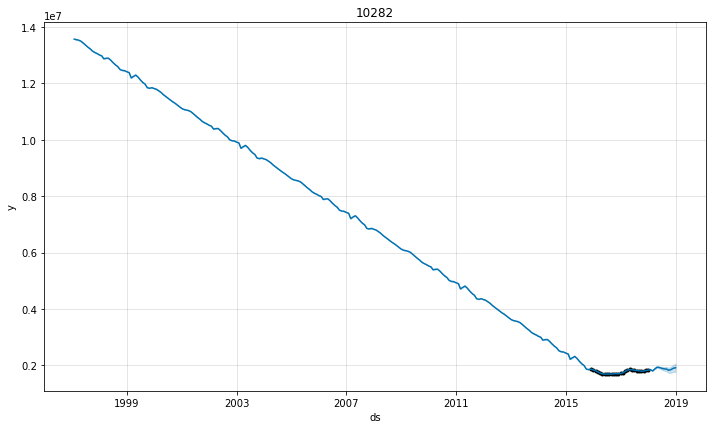

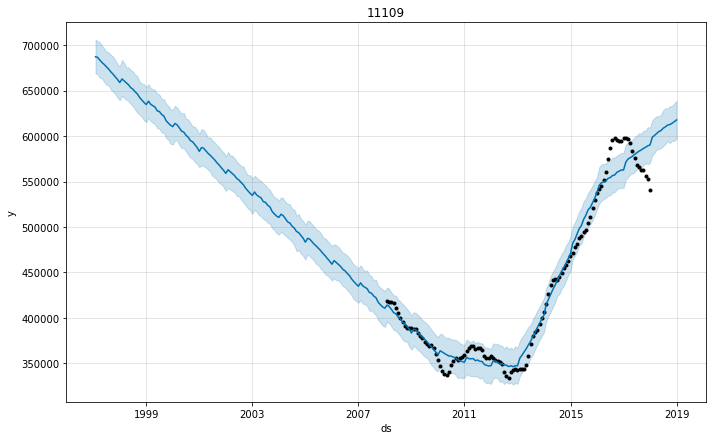

In [20]:
# Run Prophet for NYC data

# create empty df
target = pd.DataFrame()

for zipcode in nyc_group_train.groups:
    group = nyc_group_train.get_group(zipcode)
    
    #print(group)
    
    m = Prophet()
    m.fit(group)
    future = m.make_future_dataframe(periods = 12, freq = 'M')
    forecast = m.predict(future)
    m.plot(forecast)
    
    plt.title(zipcode)
    
    forecast = forecast.rename(columns = {'yhat':'yhat_'+ str(zipcode)})
    
    target = pd.merge(target, forecast.set_index('ds'), how = 'outer', 
                      left_index = True, right_index = True)

In [21]:
target = target[['yhat_' + str(zipcode) for zipcode in nyc_group_train.groups.keys()]]
target

,yhat_10004,yhat_10005,yhat_10006,yhat_10011,yhat_10017,yhat_10018,yhat_10021,yhat_10028,yhat_10069,yhat_10280,yhat_10282,yhat_11109
ds,,,,,,,,,,,,
1997-01-31,6.037910e+05,1.250511e+05,-64260.434573,-3.233371e+05,7.473711e+05,267296.860169,3.049259e+06,2.148429e+06,2.315592e+06,2.516080e+05,1.356772e+07,687379.118369
1997-02-28,5.980568e+05,1.421935e+05,-66830.786297,-2.499078e+05,7.645335e+05,263727.740418,3.061881e+06,2.227985e+06,2.304132e+06,2.502992e+05,1.355138e+07,686661.327328
1997-03-31,5.982058e+05,1.443762e+05,-63574.580379,-2.322204e+05,7.652268e+05,262770.839865,3.089610e+06,2.221800e+06,2.296846e+06,2.550955e+05,1.353083e+07,683872.608010
1997-04-30,5.976832e+05,1.474671e+05,-57280.674337,-2.131682e+05,7.672796e+05,262936.182220,3.129407e+06,2.221328e+06,2.289267e+06,2.591558e+05,1.349460e+07,681021.746523
1997-05-31,5.972416e+05,1.517597e+05,-48589.515237,-1.925860e+05,7.699763e+05,264310.740344,3.172134e+06,2.223376e+06,2.283711e+06,2.633643e+05,1.342712e+07,678836.526997
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31,1.289735e+06,1.303183e+06,897524.853003,3.536377e+06,1.500886e+06,664978.797613,8.514399e+06,4.265004e+06,1.833942e+06,1.149329e+06,1.876816e+06,612174.978893
2018-09-30,1.300666e+06,1.308077e+06,896692.899364,3.545881e+06,1.503549e+06,667347.585804,8.551624e+06,4.276955e+06,1.839014e+06,1.154794e+06,1.831276e+06,612691.637378
2018-10-31,1.309258e+06,1.312960e+06,895381.705360,3.551811e+06,1.507088e+06,668938.030565,8.591907e+06,4.291205e+06,1.843554e+06,1.159816e+06,1.853262e+06,614189.351396


In [22]:
# Get top 3 predicted zip codes

target.T['2018-12-31'].nlargest(5)


yhat_10021    8.666019e+06
yhat_10028    4.339353e+06
yhat_10011    3.581183e+06
yhat_10282    1.919888e+06
yhat_10069    1.849133e+06
Name: 2018-12-31 00:00:00, dtype: float64

In [27]:
# Get average difference between home value each month

target.diff().mean().sort_values(ascending = False)


yhat_10021    21356.502602
yhat_10011    14846.085309
yhat_10028     8330.506979
yhat_10005     4560.194654
yhat_10006     3636.519954
yhat_10280     3491.749800
yhat_10017     2935.435241
yhat_10004     2738.340787
yhat_10018     1535.491862
yhat_11109     -264.401364
yhat_10069    -1773.607061
yhat_10282   -44288.330409
dtype: float64

In [23]:
# Compare actual vs. predicted values

actual = nyc_broadband_test[nyc_broadband_test['ds'] == '2018-12-31'].sort_values(by = 'RegionName')
#actual

predicted = pd.DataFrame(target.loc['2018-12-31']).reset_index()
predicted.rename(columns = {predicted.columns[1]:'predicted'}, inplace = True)
predicted['index'] = predicted['index'].str.replace(r'yhat_', '').astype('int64')
#predicted


In [24]:
# Combine actual/predicted values into results df

results = actual.merge(predicted, left_on = "RegionName", right_on = "index")
results = results.drop(columns = ['ds', 'high_access', 'index'])
results = results.rename(columns = {'y':'actual'})
results

,RegionName,actual,predicted
0,10004,1238637.0,1.323975e+06
1,10005,1198600.0,1.324382e+06
2,10006,880018.0,8.921443e+05
3,10011,3101166.0,3.581183e+06
4,10017,1454297.0,1.519391e+06
5,10018,645483.0,6.711312e+05
6,10021,7375200.0,8.666019e+06
7,10028,3581824.0,4.339353e+06
8,10069,1658382.0,1.849133e+06
9,10280,1041060.0,1.169938e+06


In [25]:
# Determine errors - get RMSE

mean_squared_error(results['actual'], results['predicted'], squared = False)


476933.15358964604